# Adquisición y análisis de señal con ESP32 (1 kHz)

## Resumen del proyecto
En este proyecto:
1. **Generamos una señal senoidal de 10 Hz** con un generador de funciones.
2. **La adquirimos con un ESP32** usando interrupciones por *Hardware Timer* a **1 kHz** (periodo de muestreo de 1 ms).
3. **Verificamos el jitter** del ESP32 con instrumental (≈ **5 µs**).
4. **Recibimos los datos vía serial en Python** y los guardamos en un archivo CSV.
5. **En este notebook** analizamos los datos: graficamos la señal, verificamos el timestamp perfecto y calculamos la FFT.

Este flujo valida que el muestreo es correcto y prepara el camino para DSP.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1) Cargar datos desde CSV
Leemos el archivo generado por el script de logging serial.  
El archivo contiene:
- `timestamp` (datetime del PC)
- `interrupt_count` (contador de interrupciones del ESP32)
- `adc_value` (lectura ADC)

In [12]:
csv_path = r"C:\sensor-intelligence-lab\data\raw\registro.csv"
df = pd.read_csv(csv_path)

# Tipos correctos
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["interrupt_count"] = df["interrupt_count"].astype(int)
df["adc_value"] = df["adc_value"].astype(float)

df.head()

,timestamp,interrupt_count,adc_value
0,2026-02-04 14:35:45.857040,1,1950.0
1,2026-02-04 14:35:45.857040,2,1986.0
2,2026-02-04 14:35:45.857040,3,2065.0
3,2026-02-04 14:35:47.045389,1,2000.0
4,2026-02-04 14:35:47.045389,2,2025.0


## 2) Gráfica: timestamp vs ADC
Esta gráfica debe verse como una señal de 10 Hz.

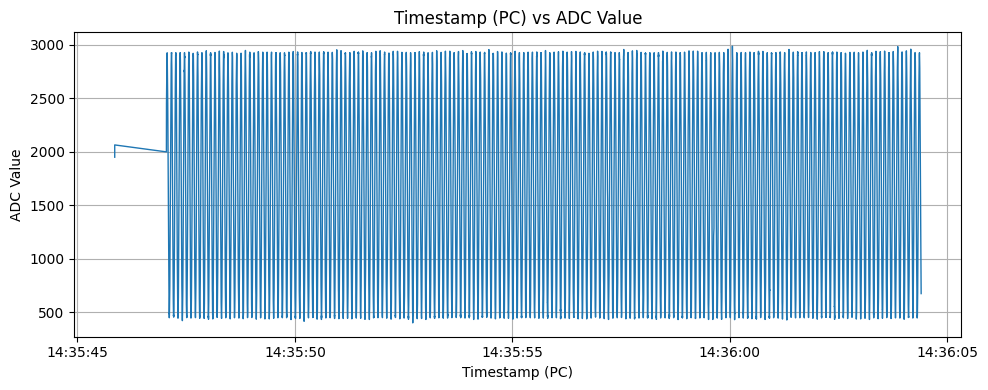

In [13]:
plt.figure(figsize=(10, 4))
plt.plot(df["timestamp"], df["adc_value"], linewidth=1)
plt.title("Timestamp (PC) vs ADC Value")
plt.xlabel("Timestamp (PC)")
plt.ylabel("ADC Value")
plt.grid(True)
plt.tight_layout()
plt.show()

## 3) Timestamp perfecto usando `interrupt_count` (CRÍTICO)
El ESP32 muestrea a **1 kHz**, así que **cada interrupt_count representa 1 ms**.  
Creamos un `timestamp_perfecto`:
- Tomamos el primer timestamp del PC como referencia.
- Construimos la línea de tiempo ideal sumando `interrupt_count * 1 ms`.

Luego comparamos `timestamp` (PC) vs `timestamp_perfecto`.

In [14]:
# Tiempo ideal (1ms por interrupción)
t0 = df["timestamp"].iloc[0]
ic0 = df["interrupt_count"].iloc[0]
ic_rel = df["interrupt_count"] - ic0  # empieza en 0
df["timestamp_perfecto"] = t0 + pd.to_timedelta(ic_rel, unit="ms")

# Drift (segundos)
df["drift_s"] = (df["timestamp"] - df["timestamp_perfecto"]).dt.total_seconds()

df[["timestamp", "timestamp_perfecto", "drift_s"]].head()

,timestamp,timestamp_perfecto,drift_s
0,2026-02-04 14:35:45.857040,2026-02-04 14:35:45.857040,0.000000
1,2026-02-04 14:35:45.857040,2026-02-04 14:35:45.858040,-0.001000
2,2026-02-04 14:35:45.857040,2026-02-04 14:35:45.859040,-0.002000
3,2026-02-04 14:35:47.045389,2026-02-04 14:35:45.857040,1.188349
4,2026-02-04 14:35:47.045389,2026-02-04 14:35:45.858040,1.187349


### Análisis del drift
Si el PC no perdió el ritmo, el drift debería ser muy cercano a 0.

Drift stats (seconds):
count    17365.000000
mean         1.183182
std          0.015570
min         -0.002000
25%          1.183149
50%          1.183382
75%          1.183681
max          1.188861
Name: drift_s, dtype: float64


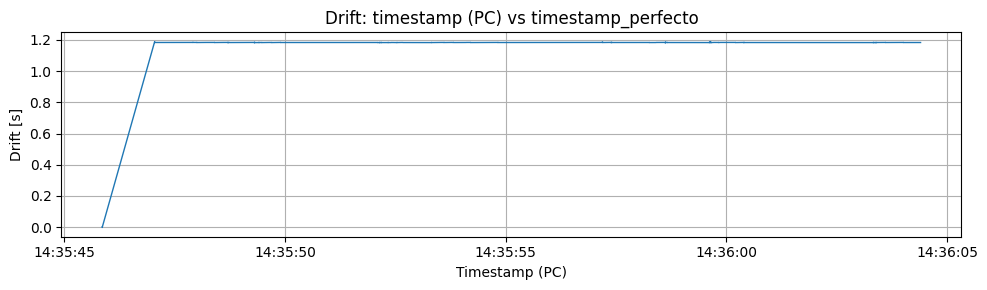

In [15]:
print("Drift stats (seconds):")
print(df["drift_s"].describe())

plt.figure(figsize=(10, 3))
plt.plot(df["timestamp"], df["drift_s"], linewidth=1)
plt.title("Drift: timestamp (PC) vs timestamp_perfecto")
plt.xlabel("Timestamp (PC)")
plt.ylabel("Drift [s]")
plt.grid(True)
plt.tight_layout()
plt.show()

## 4) FFT básica (pico ~10 Hz)
Aplicamos FFT a la señal para verificar que la frecuencia principal está alrededor de **10 Hz**.

Dominant frequency: 10.02 Hz


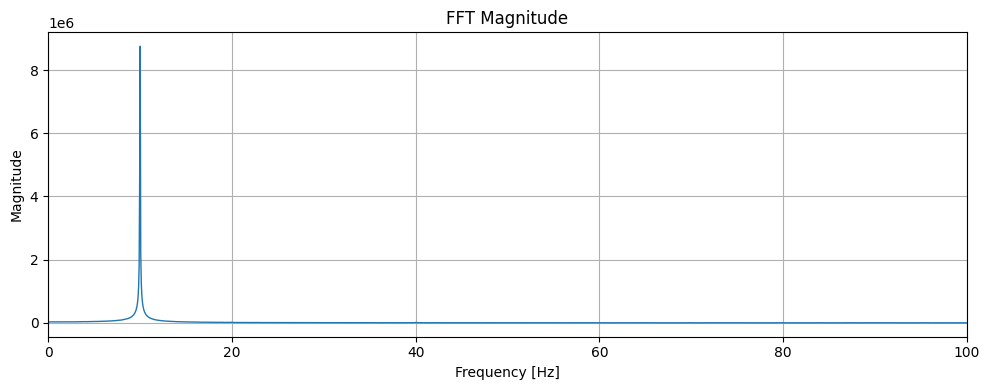

In [16]:
fs = 1000.0  # 1 kHz por el timer
signal = df["adc_value"].to_numpy()
signal = signal - np.mean(signal)  # remover componente DC

N = len(signal)
freqs = np.fft.rfftfreq(N, d=1/fs)
fft_mag = np.abs(np.fft.rfft(signal))

# Frecuencia dominante (ignorar DC)
dominant_idx = np.argmax(fft_mag[1:]) + 1
dominant_freq = freqs[dominant_idx]
print(f"Dominant frequency: {dominant_freq:.2f} Hz")

plt.figure(figsize=(10, 4))
plt.plot(freqs, fft_mag, linewidth=1)
plt.title("FFT Magnitude")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.grid(True)
plt.xlim(0, 100)  # Zoom a bajas frecuencias
plt.tight_layout()
plt.show()